In [1]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from ucimlrepo import fetch_ucirepo
from NaDropper import HighNaNDropper
from sklearn.pipeline import Pipeline
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
colors = ["#9AD0F5", "#A7E8BD", "#C5A3FF", "#FFD8B1"]

In [2]:
def build_pipeline(**args):
    pipeline = Pipeline([
        ('dropper', HighNaNDropper(threshold=0.3)),
        ('imputer', KNNImputer()),
        ('classifier', DecisionTreeClassifier(**args))
    ])
    return pipeline

In [3]:
def build_preprocess_pipeline():
    pipeline = Pipeline([
        ('imputer', KNNImputer()),
    ])
    return pipeline

In [4]:
def process_dataset(x, y, balance=False):
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, shuffle=True)
    y_train = np.ravel(y_train)
    preprocess_pipeline = build_preprocess_pipeline()
    x_train_processed = preprocess_pipeline.fit_transform(x_train)
    if balance:
        x_resampled, y_resampled = SMOTE().fit_resample(x_train_processed, y_train)
        return x_resampled, y_resampled, x_test, y_test
    else:
        return x_train_processed, y_train, x_test, y_test

In [54]:
def get_hyperparams_for_dataset(pipeline, x, y, scoring):
    param_grid = {
    'classifier__ccp_alpha': np.linspace(0, 0.25, 30),
    'classifier__max_depth': [3, 5, 10, 20, None],
    'classifier__min_samples_leaf': [2, 3, 5, 10]
    }
    search = HalvingGridSearchCV(pipeline, param_grid=param_grid, aggressive_elimination=True, n_jobs=2, scoring=scoring, cv=3)
    search.fit(x, y)
    ccp_alpha, max_depth, min_samples = search.best_params_['classifier__ccp_alpha'], search.best_params_['classifier__max_depth'], search.best_params_['classifier__min_samples_leaf']
    return {'ccp_alpha': ccp_alpha, 'max_depth': max_depth, 'min_samples': min_samples}

In [49]:
def build_for_hyperparams(params_dict, weighted):
    ccp = params_dict['ccp_alpha']
    max_depth = params_dict['max_depth']
    min_samples = params_dict['min_samples']
    pipeline = build_pipeline(ccp_alpha=ccp, max_depth=max_depth, min_samples_leaf=min_samples, class_weight='balanced' if weighted else None)

    return pipeline

In [7]:
from sklearn.model_selection import cross_val_score

def get_cv_metrics(pipeline, x, y, stratified=False):
    f1 = cross_val_score(pipeline, x, y, cv=StratifiedKFold(shuffle=True) if stratified else 5, scoring='f1_micro')
    recall = cross_val_score(pipeline, x, y, cv=StratifiedKFold(shuffle=True) if stratified else 5, scoring='recall_micro')
    accuracy = cross_val_score(pipeline, x, y, cv=StratifiedKFold(shuffle=True) if stratified else 5, scoring='accuracy')
    precision = cross_val_score(pipeline, x, y, cv=StratifiedKFold(shuffle=True) if stratified else 5, scoring='precision_micro')

    return pd.DataFrame.from_dict({'f1': f1, 'recall': recall, 'accuracy': accuracy, 'precision': precision})

In [8]:
def get_metrics(pipeline, x_test, y_test):
    y_pred = pipeline.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return pd.DataFrame.from_dict({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

In [9]:
import os.path
import pickle as pkl

def load_cache_dataset(filename: str, id: int):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            dataset = pkl.load(f)
    else:
        dataset = fetch_ucirepo(id=id)
        with open(filename, 'wb') as f:
            pkl.dump(dataset, f)
    return dataset

polish_companies_bankruptcy = load_cache_dataset('pcb.pkl', 365)
iris = load_cache_dataset('iris.pkl', 53)
iris.data.targets = LabelEncoder().fit_transform(iris.data.targets.to_numpy().reshape(-1,))

In [10]:
x_companies, y_companies, x_companies_test, y_companies_test = process_dataset(polish_companies_bankruptcy.data.features, polish_companies_bankruptcy.data.targets)
x_iris, y_iris, x_iris_test, y_iris_test = process_dataset(iris.data.features, iris.data.targets)

In [18]:
iris_unweighted = build_pipeline()
hyperparams_iris_unweighted = get_hyperparams_for_dataset(iris_unweighted, x_iris, y_iris, 'f1_micro')
hyperparams_iris_unweighted

{'ccp_alpha': np.float64(0.03125), 'max_depth': 20, 'min_samples': 3}

In [19]:
iris_weighted = build_pipeline(class_weight='balanced')
hyperparams_iris_weighted = get_hyperparams_for_dataset(iris_weighted, x_iris, y_iris, 'f1_micro')
hyperparams_iris_weighted

{'ccp_alpha': np.float64(0.010416666666666666),
 'max_depth': 5,
 'min_samples': 3}

In [55]:
pcb_unweighted = build_pipeline()
hyperparams_pcb_unweighted = get_hyperparams_for_dataset(pcb_unweighted, x_companies, y_companies, 'f1')
hyperparams_pcb_unweighted

{'ccp_alpha': np.float64(0.0), 'max_depth': None, 'min_samples': 5}

In [56]:
pcb_weighted = build_pipeline(class_weight='balanced')
hyperparams_pcb_weighted = get_hyperparams_for_dataset(pcb_weighted, x_companies, y_companies, 'f1')
hyperparams_pcb_weighted

{'ccp_alpha': np.float64(0.15517241379310345),
 'max_depth': 3,
 'min_samples': 5}

## Inquiry into tree structure for various combinations assembled

### Default tree

In [11]:
default_tree = build_pipeline()
default_tree.fit(x_iris, y_iris)

Pipeline(steps=[('dropper', HighNaNDropper(threshold=0.3)),
                ('imputer', KNNImputer()),
                ('classifier', DecisionTreeClassifier())])

[Text(0.5, 0.9, 'x[2] <= 2.45\ngini = 0.667\nsamples = 112\nvalue = [37, 38, 37]'),
 Text(0.375, 0.7, 'gini = 0.0\nsamples = 37\nvalue = [37, 0, 0]'),
 Text(0.4375, 0.8, 'True  '),
 Text(0.625, 0.7, 'x[3] <= 1.75\ngini = 0.5\nsamples = 75\nvalue = [0, 38, 37]'),
 Text(0.5625, 0.8, '  False'),
 Text(0.5, 0.5, 'x[2] <= 4.95\ngini = 0.172\nsamples = 42\nvalue = [0, 38, 4]'),
 Text(0.25, 0.3, 'x[3] <= 1.65\ngini = 0.051\nsamples = 38\nvalue = [0, 37, 1]'),
 Text(0.125, 0.1, 'gini = 0.0\nsamples = 37\nvalue = [0, 37, 0]'),
 Text(0.375, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.75, 0.3, 'x[3] <= 1.65\ngini = 0.375\nsamples = 4\nvalue = [0, 1, 3]'),
 Text(0.625, 0.1, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.875, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.75, 0.5, 'gini = 0.0\nsamples = 33\nvalue = [0, 0, 33]')]

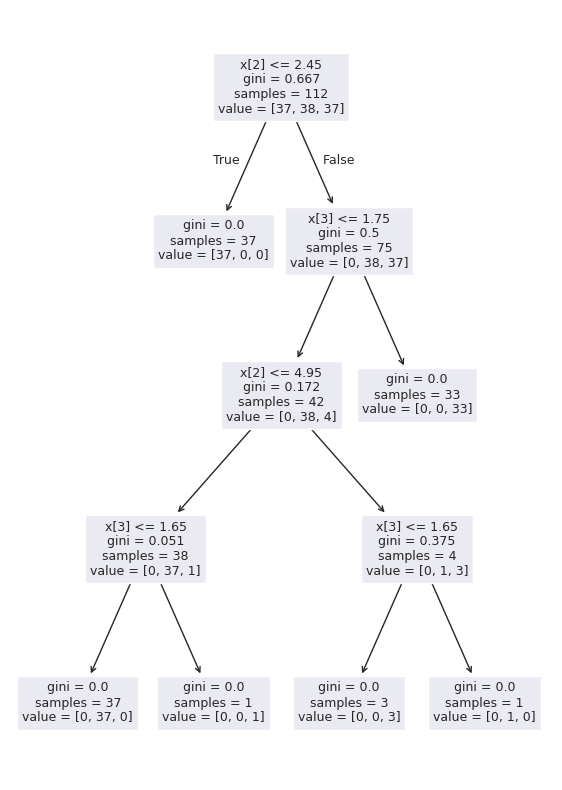

In [12]:
_, ax = plt.subplots(figsize=(7,10))
plot_tree(default_tree['classifier'], ax=ax)

### A tree with higher-than-optimal cpp_alpha

In [13]:
ccp_tree = build_pipeline(ccp_alpha=0.75)
ccp_tree.fit(x_iris, y_iris)

Pipeline(steps=[('dropper', HighNaNDropper(threshold=0.3)),
                ('imputer', KNNImputer()),
                ('classifier', DecisionTreeClassifier(ccp_alpha=0.75))])

[Text(0.5, 0.5, 'gini = 0.667\nsamples = 112\nvalue = [37, 38, 37]')]

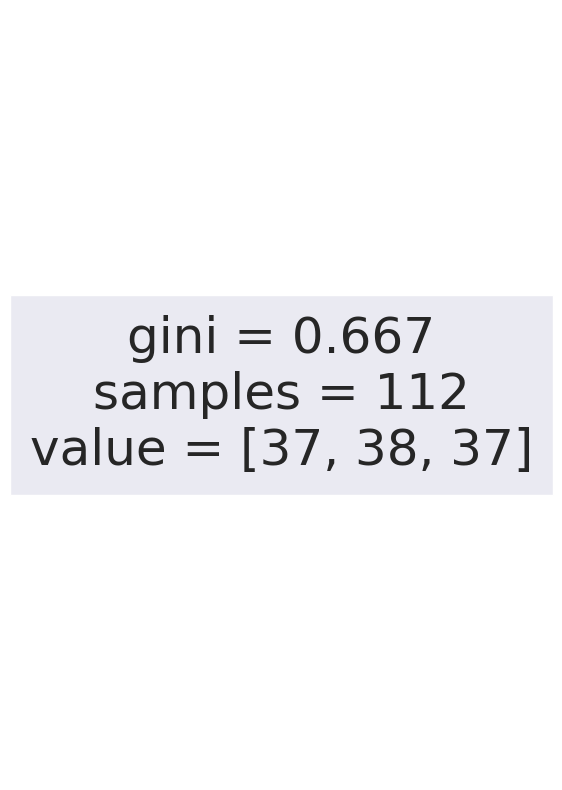

In [14]:
_, ax = plt.subplots(figsize=(7,10))
plot_tree(ccp_tree['classifier'], ax=ax)

### A tree with larger-than-optimal min_samples_leaf

[Text(0.5, 0.9, 'x[3] <= 0.8\ngini = 0.667\nsamples = 112\nvalue = [37, 38, 37]'),
 Text(0.3333333333333333, 0.7, 'gini = 0.0\nsamples = 37\nvalue = [37, 0, 0]'),
 Text(0.41666666666666663, 0.8, 'True  '),
 Text(0.6666666666666666, 0.7, 'x[3] <= 1.75\ngini = 0.5\nsamples = 75\nvalue = [0, 38, 37]'),
 Text(0.5833333333333333, 0.8, '  False'),
 Text(0.5, 0.5, 'x[2] <= 4.85\ngini = 0.172\nsamples = 42\nvalue = [0, 38, 4]'),
 Text(0.3333333333333333, 0.3, 'x[0] <= 5.15\ngini = 0.054\nsamples = 36\nvalue = [0, 35, 1]'),
 Text(0.16666666666666666, 0.1, 'gini = 0.32\nsamples = 5\nvalue = [0, 4, 1]'),
 Text(0.5, 0.1, 'gini = 0.0\nsamples = 31\nvalue = [0, 31, 0]'),
 Text(0.6666666666666666, 0.3, 'gini = 0.5\nsamples = 6\nvalue = [0, 3, 3]'),
 Text(0.8333333333333334, 0.5, 'gini = 0.0\nsamples = 33\nvalue = [0, 0, 33]')]

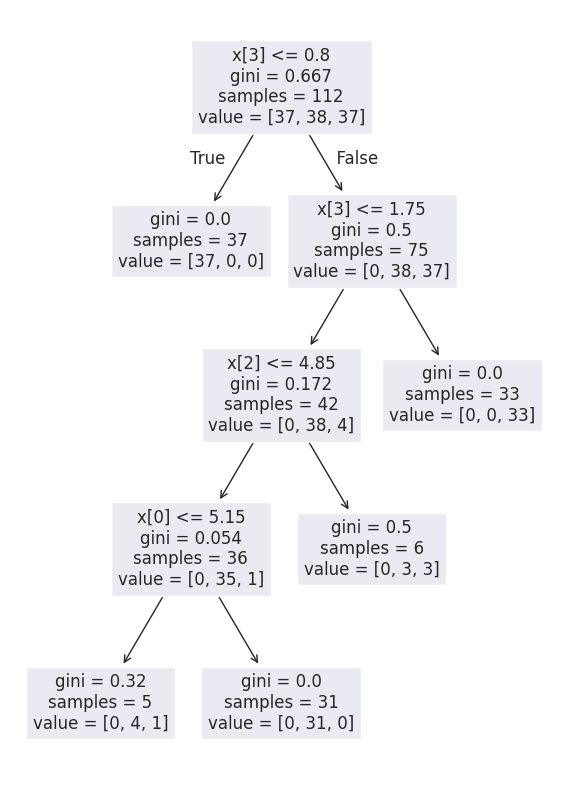

In [15]:
tree_samples_leaf = build_pipeline(min_samples_leaf=5)
tree_samples_leaf.fit(x_iris, y_iris)
_, ax = plt.subplots(figsize=(7,10))
plot_tree(tree_samples_leaf['classifier'], ax=ax)

### A tree with smaller-than-optimal max_depth

[Text(0.4, 0.8333333333333334, 'x[2] <= 2.45\ngini = 0.667\nsamples = 112\nvalue = [37, 38, 37]'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 37\nvalue = [37, 0, 0]'),
 Text(0.30000000000000004, 0.6666666666666667, 'True  '),
 Text(0.6, 0.5, 'x[3] <= 1.75\ngini = 0.5\nsamples = 75\nvalue = [0, 38, 37]'),
 Text(0.5, 0.6666666666666667, '  False'),
 Text(0.4, 0.16666666666666666, 'gini = 0.172\nsamples = 42\nvalue = [0, 38, 4]'),
 Text(0.8, 0.16666666666666666, 'gini = 0.0\nsamples = 33\nvalue = [0, 0, 33]')]

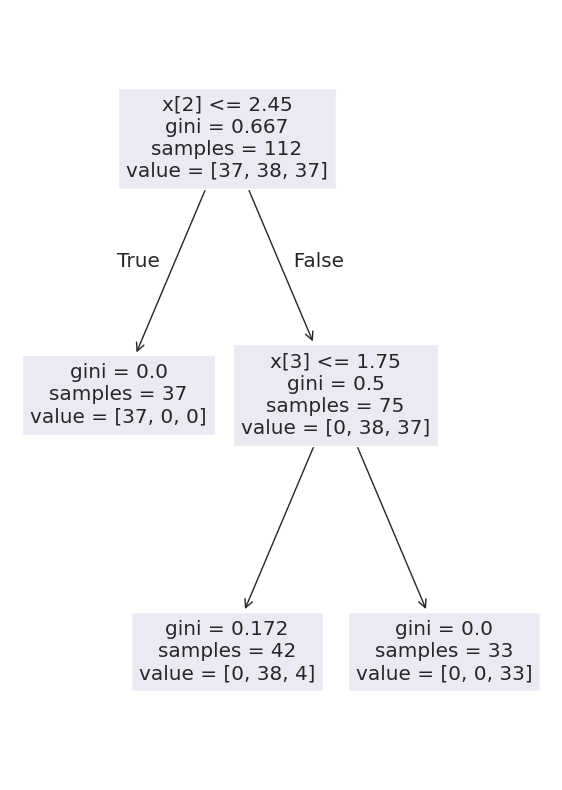

In [16]:
max_depth_tree = build_pipeline(max_depth=2)
max_depth_tree.fit(x_iris, y_iris)
_, ax = plt.subplots(figsize=(7,10))
plot_tree(max_depth_tree['classifier'], ax=ax)

# Cross-validation stratification effect

## Unweighted iris pipeline with good hyperparams

<Axes: >

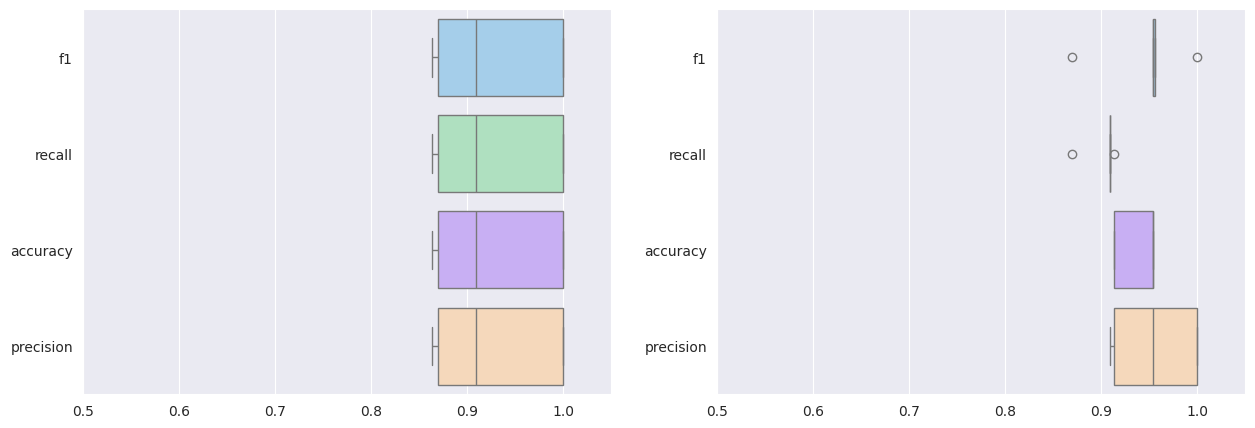

In [39]:
iris_pipeline_unweighted = build_for_hyperparams(hyperparams_iris_unweighted, False)
iris_metrics_unweighted = get_cv_metrics(iris_pipeline_unweighted, x_iris, y_iris, False)
iris_metrics_unweighted_stratified = get_cv_metrics(iris_pipeline_unweighted, x_iris, y_iris, True)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_xlim(0.5, 1.05)
ax2.set_xlim(0.5, 1.05)
sns.boxplot(data=iris_metrics_unweighted, palette=colors, orient='h', ax=ax1)
sns.boxplot(data=iris_metrics_unweighted_stratified, palette=colors, orient='h', ax=ax2)

## Weighted iris pipeline with good hyperparams

<Axes: >

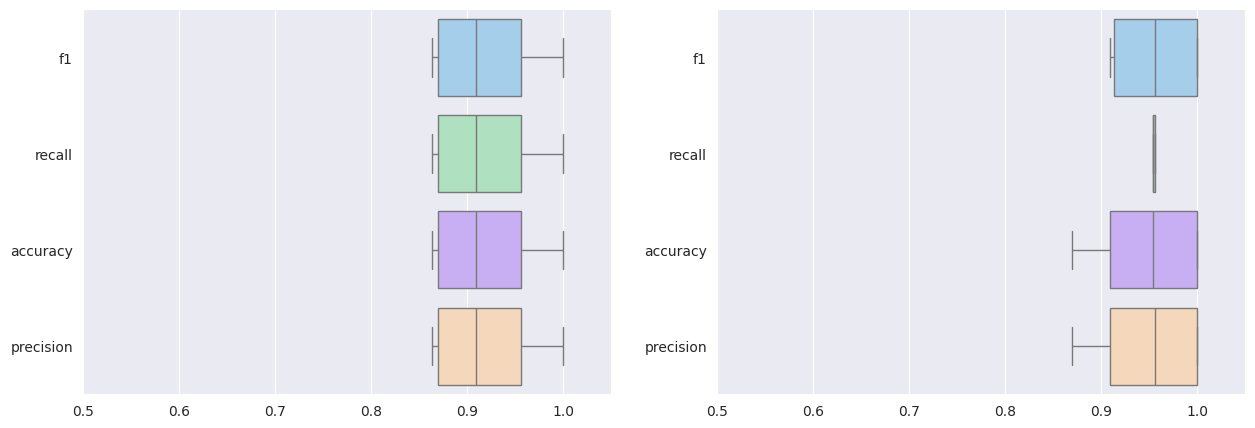

In [38]:
iris_pipeline_weighted = build_for_hyperparams(hyperparams_iris_weighted, True)
iris_metrics_weighted = get_cv_metrics(iris_pipeline_weighted, x_iris, y_iris, False)
iris_metrics_weighted_stratified = get_cv_metrics(iris_pipeline_weighted, x_iris, y_iris, True)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_xlim(0.5, 1.05)
ax2.set_xlim(0.5, 1.05)
sns.boxplot(data=iris_metrics_weighted, palette=colors, orient='h', ax=ax1)
sns.boxplot(data=iris_metrics_weighted_stratified, palette=colors, orient='h', ax=ax2)

## Unweighted PCB pipeline with good hyperparams

<Axes: >

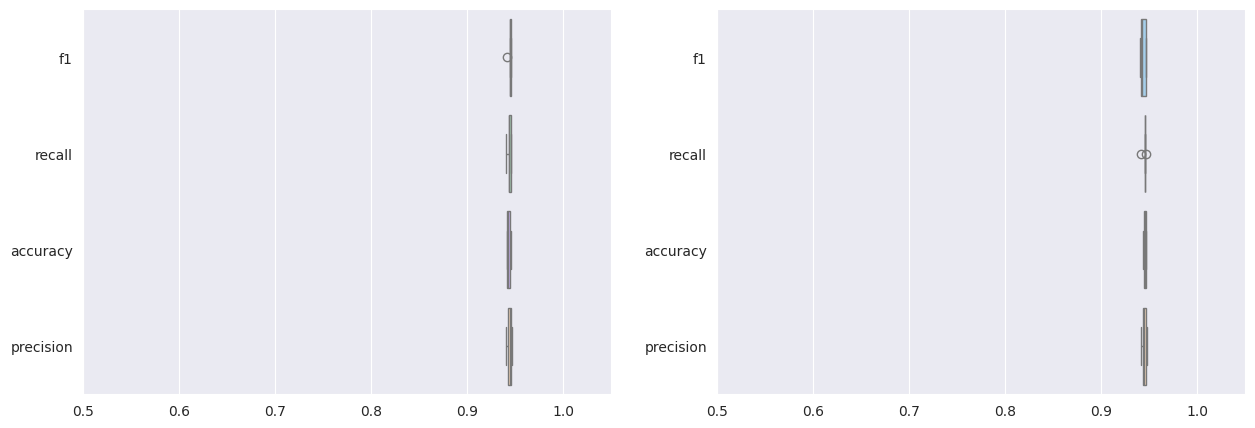

In [57]:
pcb_pipeline_unweighted = build_for_hyperparams(hyperparams_pcb_unweighted, False)
pcb_metrics_unweighted = get_cv_metrics(pcb_pipeline_unweighted, x_companies, y_companies, False)
pcb_metrics_unweighted_stratified = get_cv_metrics(pcb_pipeline_unweighted, x_companies, y_companies, True)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_xlim(0.5, 1.05)
ax2.set_xlim(0.5, 1.05)
sns.boxplot(data=pcb_metrics_unweighted, palette=colors, orient='h', ax=ax1)
sns.boxplot(data=pcb_metrics_unweighted_stratified, palette=colors, orient='h', ax=ax2)

## Weighted PCB piepline with good hyperparams

<Axes: >

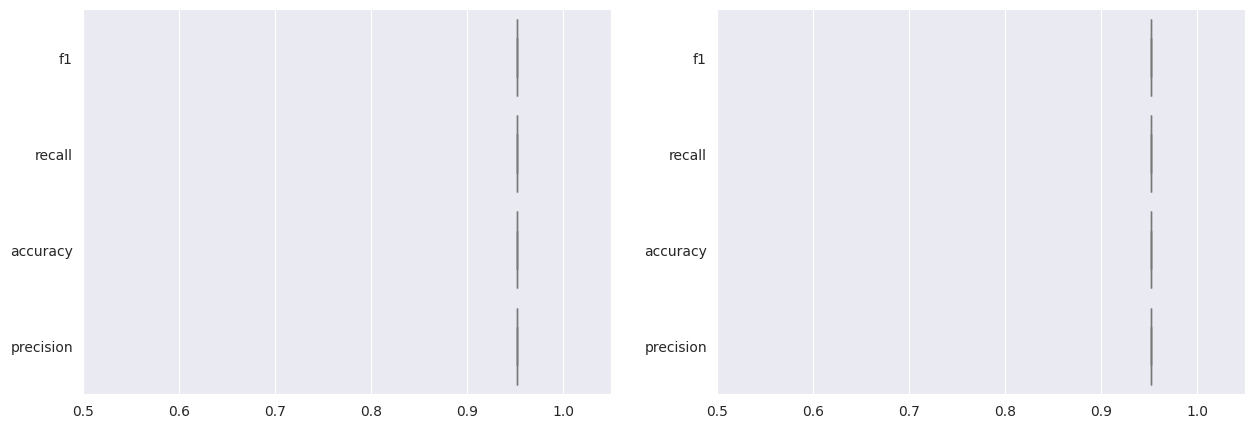

In [58]:
pcb_pipeline_weighted = build_for_hyperparams(hyperparams_pcb_weighted, True)
pcb_metrics_weighted = get_cv_metrics(pcb_pipeline_weighted, x_companies, y_companies, False)
pcb_metrics_weighted_stratified = get_cv_metrics(pcb_pipeline_weighted, x_companies, y_companies, True)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_xlim(0.5, 1.05)
ax2.set_xlim(0.5, 1.05)
sns.boxplot(data=pcb_metrics_weighted, palette=colors, orient='h', ax=ax1)
sns.boxplot(data=pcb_metrics_weighted_stratified, palette=colors, orient='h', ax=ax2)

# Summary

## Hyperparams

### ccp_alpha

Too large value may cause the tree to collapse into a single node